# ML / DL Prototype 

Time Estimate: 25 - 30 Hours / 50 - 60 Hours (depending on if you decide to build both prototypes)
The goal of this step is to find a machine learning or deep learning approach that works for your problem, and then show that the approach you choose is a viable one. Since the application has not been deployed to production yet, we’ll call it a prototype.

For this step, you’ll build your prototype in a Jupyter notebook. Depending on your problem, you’ll be using a more ‘traditional’ machine learning (ML) technique or a deep learning (DL) technique. Your goal is to come up with a working implementation of your prototype in a Jupyter notebook. This prototype could work on a subset of the data but demonstrates that your approach to solving the problem is a viable one based on the following criteria:
- The data has been reasonably split into training, validation, and test sets.
- You have used the correct metric(s) to evaluate the performance of your
algorithm.
- The performance of your algorithm is ‘good enough’ as determined by your mentor.

### Rubric

- The submission shows that the student understands how to design, implement, and justify a suitable machine learning and/or deep learning approach to a problem.
- The submission demonstrates that the student made thoughtful decisions about validating and testing the approach:
    - The data has been reasonably split into training, validation, and test sets
    - The ML/DL algorithm chosen for the approach makes sense in the context of the problem
    - The student has used the correct metric(s) to evaluate the performance of their algorithm
    - The performance of their algorithm is ‘good enough’ to meet the requirements of the business problem

- Well-documented GitHub repository and code. The Jupyter notebooks for the code provide step-by-step documentation that’s easy to follow. 

## ML Prototype

Summary: Light Gradient boosting optimized with SK Optimize

Pipeline
- feature extraction 
    - audio limit    
- oversampling using ADASYN
- feature standardization using Quantile Transformer
- PCA (search components)
- LGBM
    - thorough hyperparameter search with skoptimize

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

Load dataset including raw audio and previously computed features.

In [24]:
df = pd.read_pickle('data/features/df.pkl')

In [38]:
extract_limit = df.extract_limit.values[0]  # previously found good audio limit
sr = df.sr.values[0] # sample rate

# cannot use select_dtypes since features stored under *int* index *names*
X = df[[c for c in df.columns.values if isinstance(c, int)] + ['audio', 'sr']]
y = df['emotion_class']

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=0)

print('limit ', extract_limit)
print('sr ', sr)
print('X ', X.shape)
print('y', y.shape)
print('X train ', X_train.shape)
print('y train ', y_train.shape)
print('X test', X_test.shape)
print('y train', y_test.shape)

limit  110250
sr  22050.0
X  (13700, 162)
y (13700,)
X train  (10960, 162)
y train  (10960,)
X test (2740, 162)
y train (2740,)


## Experiment

Cross validate extraction hyperparams using silhouette score.

mfcc 
- n_mfcc in [13, 26] 
- dct_type in [1, 2, 3]

chroma_stft
- n_fft=220 for .01 s and 2205 for .1 s, hop length can be 1/2 or 1/4 the window size
- hop_length
- m_chroma=12
- center=T/F

melspectrogram 
- n_fft=220 for .01 s and 2205 for .1 s, hop length can be 1/2 or 1/4 the window size
- hop_length

In [16]:
import librosa

def extract_mfcc_mean(audio, sr, **kwargs):
    return np.mean(librosa.feature.mfcc(y=audio, sr=sr, **kwargs).T, axis=0)


def extract_chroma_mean(audio, sr, **kwargs):
    stft = np.abs(librosa.stft(audio))
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, **kwargs).T, axis=0)


def extract_mel_mean(audio, sr, **kwargs):
    return np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, **kwargs).T, axis=0)
     

In [17]:
def run_extract(df, lim, func, **kwargs):
    X = []
    for i, r in df.iterrows():
        audio = r.audio if lim is None else r.audio[:lim]
        X.append(func(audio, r.sr, **kwargs))
    
    return np.array(X)

In [18]:
# test MFCC hyperparams
xs = list(range(10, 30, 2))
scores = list()
for n_mfcc in xs:   
    feats = run_extract(X_train, extract_limit, extract_mfcc, n_mfcc=n_mfcc)
    scores.append(silhouette_score(feats, y_train))

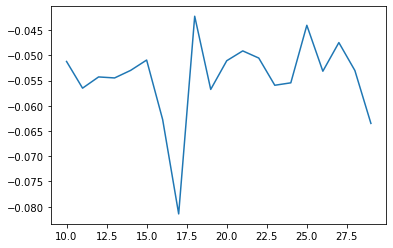

In [10]:
plt.plot(xs, scores);

In [28]:
# test chroma hyperparams
xs = list(range(2, 14))
scores = list()
for n_chroma in xs:  
    feats = run_extract(X_train, extract_limit, extract_chroma, n_chroma=n_chroma)
    scores.append(silhouette_score(feats, y_train))

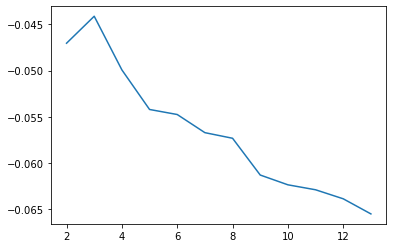

In [29]:
plt.plot(xs, scores);

## ML Prototype

Pipeline
- oversampling using ADASYN
- feature standardization using Quantile Transformer
- PCA (search components)
- LGBM
    - thorough hyperparameter search with skoptimize



In [21]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import ADASYN
import lightgbm as lgb
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


pipe = Pipeline([
    ('oversample', ADASYN(random_state=0, n_jobs=-1)), 
    ('standardize', QuantileTransformer(output_distribution='normal', random_state=0)),
    ('decomposition', PCA(random_state=0)),
    ('estimator', lgb.LGBMClassifier(objective='multiclass', class_weight='balanced')),
])
params = {
    'decomposition__n_components': list(range(10, 101)) 
}
search = GridSearchCV(pipe, params, scoring='f1_weighted', cv=5, n_jobs=-1) 

search.fit(X_train, y_train)
search.best_params_

{'decomposition__n_components': 97}

In [35]:
import seaborn as sns

def grid_search_plot(search, x, hue=None, col=None):
    result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
    grid = sns.relplot(data=result_df,
                kind='line',
                x='param_' + x,
                y='mean_test_score',
                hue='param_' + hue if hue else None, 
                col='param_' + col if col else None)
    grid.fig.set_size_inches(15, 10)

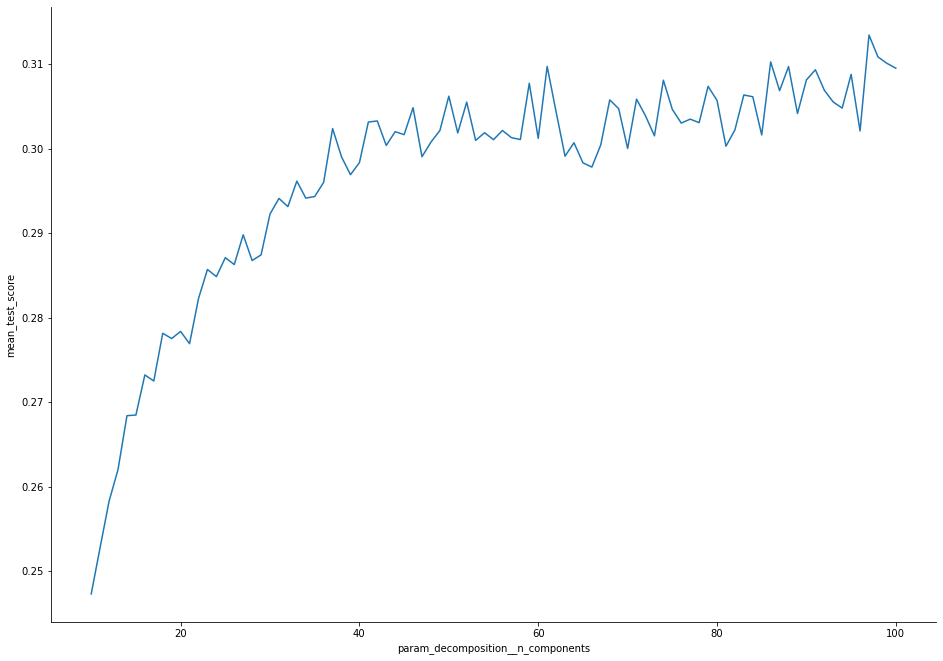

In [36]:
grid_search_plot(search, 'decomposition__n_components');

Looks like 50 is a good tradeoff between components and score. 

Next I will tune the LGBMClassifier using Bayesian Optimization...

In [41]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import TimerCallback, DeadlineStopper


pipe = Pipeline([
    ('oversample', ADASYN(random_state=0, n_jobs=-1)), 
    ('standardize', QuantileTransformer(output_distribution='normal', random_state=0)),
    ('decomposition', PCA(random_state=0, n_components=50)),
    ('model', lgb.LGBMClassifier(objective='multiclass', class_weight='balanced')),
])

# https://lightgbm.readthedocs.io/en/v3.2.1/pythonapi/lightgbm.LGBMClassifier.html
search_spaces = {
        'model__boosting_type': Categorical(['gbdt', 'dart', 'goss']),               # def=gbdt
        'model__num_leaves': Integer(10, 100),                                       # def=31
        'model__max_depth': Integer(1, 20),                                          # def=-1 no limit
        'model__learning_rate': Real(low=0.001, high=0.5, prior='log-uniform'),      # def=0.1
        'model__n_estimators': Integer(low=50, high=500),                            # def=100    
        'model__min_split_gain': Real(0.0, 1.0),                                     # def=0
        'model__min_child_weight': Real(low=0.00001, high=0.1, prior='log-uniform'), # def=1e-3
        'model__min_child_samples': Integer(10, 30),                                 # def=20
#         'model__reg_alpha': Integer(0, 100),                                         # def=0
#         'model__reg_lambda': Integer(0, 100),                                        # def=0
        
#         'model__subsample': [1.0],
#         'model__subsample_freq': [0],
#         'model__colsample_bytree': [1],
    }

In [42]:
%%time

# number of parameter settings that are sampled, trades off runtime vs solution quality
n_iter = 2

# time-based stopping criterion
budget_minutes = 120

cbs = [TimerCallback(), DeadlineStopper(60 * budget_minutes)]
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_spaces,
    n_iter=n_iter,
    scoring='f1_weighted',
    n_jobs=-1,
    n_points=1,  # number of parameter settings to sample in parallel
    refit=True,  # after opt, refits on entire dataset, so predictions can be made
    verbose=1,
    cv=3
)

opt.fit(X_train, y_train, callback=cbs)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.3s finished


CPU times: user 6min 37s, sys: 2.86 s, total: 6min 40s
Wall time: 3min 4s


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('oversample',
                                         ADASYN(n_jobs=-1, random_state=0)),
                                        ('standardize',
                                         QuantileTransformer(output_distribution='normal',
                                                             random_state=0)),
                                        ('decomposition',
                                         PCA(n_components=50, random_state=0)),
                                        ('model',
                                         LGBMClassifier(class_weight='balanced',
                                                        objective='multiclass'))]),
              n_iter=2, n_jobs=-1, scoring='f1_weighted',
              search...
                             'model__min_child_weight': Real(low=1e-05, high=0.1, prior='log-uniform', transform='normalize'),
                             'model__min_split_gain': Real(l

In [43]:
f'cv={opt.best_score_:.4f}'

'cv=0.3115'

In [44]:
opt.best_params_

OrderedDict([('model__boosting_type', 'dart'),
             ('model__learning_rate', 0.04020229609548579),
             ('model__max_depth', 13),
             ('model__min_child_samples', 29),
             ('model__min_child_weight', 0.00010600217702290037),
             ('model__min_split_gain', 0.14370387930901055),
             ('model__n_estimators', 369),
             ('model__num_leaves', 51)])

## DL Prototype

Summary: 
1. CNN on melspectrogram followed by Linear Classifier
- following ideas from: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
2. Create sequence of features and use LSTM

Mel Spectrograms
- regular spectrogram: frequency vs. time
- mel spectrogram: mel scale vs time, colors/intensity of values on decibel scale not amplitude

In [90]:
from math import ceil

windows = ceil(extract_limit / 512)
windows

216

In [110]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

X_mfcc = []
for i, r in tqdm_notebook(X.iterrows()):
    mfcc = librosa.feature.mfcc(y=r.audio[:extract_limit], sr=r.sr)
    # pad the tail of shorter samples with 0s
    mfcc_pad = librosa.util.fix_length(mfcc, size=windows)
    X_mfcc.append(mfcc_pad)

X_mfcc = np.array(X_mfcc)
X_mfcc.shape

0it [00:00, ?it/s]

(13700, 20, 216)

In [106]:
# TODO: 
# - randomly time shift signal

# n_mels=64, n_fft=1024, hop_length

# ----------------------------
# Shifts the signal to the left or right by some percent. Values at the end
# are 'wrapped around' to the start of the transformed signal.
# ----------------------------
@staticmethod
def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

    # Frequency mask — randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram.
    # Time mask — similar to frequency masks, except that we randomly block out ranges of time from the spectrogram by using vertical bars.
    

    
# ----------------------------
# Augment the Spectrogram by masking out some sections of it in both the frequency
# dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
# overfitting and to help the model generalise better. The masked sections are
# replaced with the mean value.
# ----------------------------
@staticmethod
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [113]:
from torch.utils.data import DataLoader, Dataset, random_split

class MeldDS(Dataset):
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i]
    
ds = MeldDS(X_mfcc)

In [121]:
from math import floor, ceil

lengths = [floor(len(ds) * 0.9), ceil(len(ds) * 0.1)]
train_ds, test_ds = random_split(ds, lengths)

batch_size = 32  # 64, 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [125]:
# input: (batch_size, num_channels, mfcc bands, timesteps
from torch.nn import init
from torch import nn
import torch.nn.functional as F


class AudioClassifier (nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        return self.lin(x)


In [127]:
import torch
model = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = model.to(device)
next(model.parameters()).device

device(type='cpu')